# MODEL CODE - UNIDIRECTIONAL RNN WITH LSTM CELLS

### Removing unwanted data

SECTION BELOW IS DONE BY HELENA AND DOES NOT NEED TO BE RUN.

In [ ]:
def remove_unwanted_data(filename_in='', filename_out='',  invalid=True, duplicates=True, salts=True, stereochem=True, canonicalize=True):
    """Pre-processing of SMILES based on the user-defined parameters
            :param filename_in     path to the file containing the SMILES to pretreat (SMILES only) -- default = ChEMBL
            :param filename_out    path for file export -- default = ../data/
            :param invalid         if True (default), removes invalid SMILES
            :param duplicates      if True (default), removes duplicates
            :param salts           if True (default), removes salts
            :param stereochem      if True (default), removes stereochemistry
            :param canonicalize    if True (default), produces canonical SMILES
    """

    from preprocessor import Preprocessor
    p = Preprocessor(filename_in)

    print(Fore.GREEN + 'Pre-processing of "' + filename_in + '" started.')


    # user-defined pretreatment
    if invalid:
        p.remove_not_valid()
        print(Fore.GREEN + ' invalid SMILES - removed.')
        print(Style.RESET_ALL)

    if duplicates:
        p.remove_duplicates()
        print(Fore.GREEN + ' duplicate SMILES - removed.')
        print(Style.RESET_ALL)

    if salts:
        p.remove_salts()
        print(Fore.GREEN + ' salts - removed.')
        print(Style.RESET_ALL)

    if stereochem:
        p.remove_stereochem()
        print(Fore.GREEN + ' stereochemistry - removed.')
        print(Style.RESET_ALL)

    if canonicalize:
        p.canonicalize()
        print(Fore.GREEN + ' canonicalized SMILES.')
        print(Style.RESET_ALL)

    #save data to file
    p.save_data(filename_out)

    data = p.get_data()
    print(data[:5])


#remove_unwanted_data(filename_in='ChEMBL', filename_out='preprocessed_data.csv')
#data_no_descriptors=pd.read_csv('preprocessed_data.csv')

### Importing packages 

In [1]:
import numpy as np
from collections import OrderedDict
from itertools import chain
from rdkit import Chem
from sklearn.utils import shuffle
import tensorflow as tf
import pandas as pd
import re
from colorama import Fore, Style
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from Elements import elements, lc_elements

### Loading in preprocessed data

This section of code loads in the seperate preprocessed data sections and makes one panda dataframe. 

In [2]:
csv_directory = 'C:/Users/20192032/OneDrive - TU Eindhoven/Documents/GitHub/OgoComputationalBiologyGroup10/full_code/preprocessed_data'

csv_files = [file for file in os.listdir(csv_directory) if file.endswith('.csv')]

dataframes = []

for csv_file in csv_files:
    file_path = os.path.join(csv_directory, csv_file)
    df = pd.read_csv(file_path, header=None)
    dataframes.append(df)

pp_data = pd.concat(dataframes, ignore_index=True)
pp_data.columns = ['canonical_smiles']
pp_data.drop_duplicates(subset='canonical_smiles', inplace=True) #removing duplicate SMILES. (as it was not done by Helena, due to error)

In [3]:
print(pp_data) #when you want to iterate through SMILES recall as pp_data["canonical_smiles"]

                                          canonical_smiles
0                             Cc1cc(-c2csc(N=C(N)N)n2)cn1C
1        CCC(C)C(NC(=O)C(CC(C)C)NC(=O)C(NC(=O)C(N)CCSC)...
2        CCCCC1NC(=O)C(NC(=O)C(CC(C)C)NC(=O)C(NC(=O)C(C...
3        CC(C)CC1NC(=O)CNC(=O)C(c2ccc(O)cc2)NC(=O)C(C(C...
4                   Brc1cccc(Nc2ncnc3ccncc23)c1NCCN1CCOCC1
...                                                    ...
2299991           O=S(=O)(CCC(F)(F)F)N1C2CCC1CC(n1cccn1)C2
2299992            CCOCC(=O)N1CCC(C(=O)N2CC(c3nccs3)C2)CC1
2299993  Cc1ccccc1CN1C(=O)c2ccccc2Sc2ccc(C(=O)NCCN3CCOC...
2299994  COc1cccc(N2CCN(C(=O)C3C4C=CC5(CN(Cc6ccccc6Cl)C...
2299995     Cc1ccc(S(=O)(=O)Cn2nnnc2CN2CCCC3(CCCCC3)C2)cc1

[2107759 rows x 1 columns]


### Visualising random structures in ChEMBL.

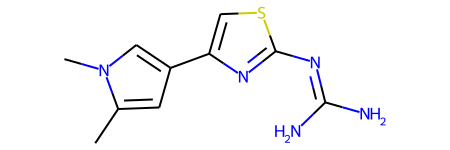

In [4]:
Chem.MolFromSmiles(pp_data['canonical_smiles'].iloc[0])

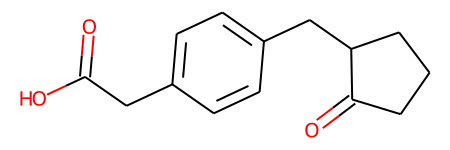

In [5]:
Chem.MolFromSmiles(pp_data['canonical_smiles'].iloc[60000])

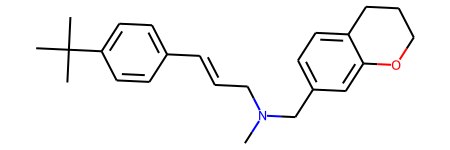

In [6]:
Chem.MolFromSmiles(pp_data['canonical_smiles'].iloc[230000])

### Creating dictionary from preprocessed data

In this part a dictionary is made that maps each unique character to an unique integer. 

In [16]:
def create_dictionary(smiles_dataset):
    """
    Create dictionaries for tokenizing SMILES strings.

    This function takes a dataset of SMILES strings and creates dictionaries
    for tokenizing the strings into integer sequences. It extracts symbols, one-letter
    and two-letter chemical element tokens from the SMILES strings, checks if they are chemically valid
    and assigns unique integer indices to each token.

    Parameters:
    - smiles_dataset (list): A list of SMILES strings.

    Returns:
    tuple: A tuple of dictionaries.
        - char_to_int (dict): A dictionary mapping characters to integer indices.
        - int_to_char (dict): A dictionary mapping integer indices to characters.
    
    imports from Elements module:
    - `elements`: list of chemical valid two-letter chemical elements.
    - `lc_elements`: list of one-letter chemical elements (both lower and uppercase) and valid SMILES symbols. 
    """
    one_letter_tokens = set()
    two_letter_tokens = set()
    
    pattern_one = re.compile('[A-Za-z0-9%\-+=#\(\)\[\]]')
    pattern_two = re.compile('[A-Z][a-z]')

    for smiles in smiles_dataset:
        matches_one = pattern_one.findall(smiles)
        matches_two = pattern_two.findall(smiles)

        one_letter_tokens.update(matches_one)
        two_letter_tokens.update(matches_two)
    
    two_letter_tokens = two_letter_tokens.intersection(elements) #removes all tokens not found in elements
    #one_letter_tokens = one_letter_tokens.intersection(lc_elements) #removes all tokens not found in lc_elements
    
    unique_char = one_letter_tokens | two_letter_tokens #combining sets to one set.
    
    char_list = list(unique_char)
    
    char_to_int = {char: index for index, char in enumerate(char_list)}
    int_to_char = {index: char for index, char in enumerate(char_list)}
    
    char_to_int.update({"E" : len(char_to_int)}) #adding End character
    char_to_int.update({"G" : len(char_to_int)}) #adding starting character
    
    int_to_char.update({len(int_to_char) : "E"})
    int_to_char.update({len(int_to_char) : "G"})
    
    return char_to_int, int_to_char

smiles_list = pp_data['canonical_smiles'].tolist()
dictionaries = create_dictionary(smiles_list)
char_to_int = dictionaries[0]
int_to_char = dictionaries[1]

In [17]:
char_to_int

{'Rb': 0,
 'M': 1,
 'Kr': 2,
 '%': 3,
 'o': 4,
 '#': 5,
 '0': 6,
 'e': 7,
 't': 8,
 'g': 9,
 'r': 10,
 'B': 11,
 'p': 12,
 'L': 13,
 'T': 14,
 'Ba': 15,
 '8': 16,
 'R': 17,
 'I': 18,
 'Al': 19,
 'Te': 20,
 'Si': 21,
 '-': 22,
 'Ra': 23,
 'Sn': 24,
 '2': 25,
 'a': 26,
 ')': 27,
 '1': 28,
 'A': 29,
 '+': 30,
 'Zn': 31,
 '7': 32,
 '4': 33,
 'S': 34,
 'Z': 35,
 's': 36,
 'Ag': 37,
 'Xe': 38,
 'Na': 39,
 'Sc': 40,
 'F': 41,
 'Cs': 42,
 'Mg': 43,
 'c': 44,
 'n': 45,
 ']': 46,
 'At': 47,
 'H': 48,
 'b': 49,
 'Br': 50,
 '(': 51,
 '=': 52,
 'l': 53,
 'C': 54,
 'X': 55,
 '9': 56,
 'Cl': 57,
 'He': 58,
 '5': 59,
 'Sr': 60,
 'Se': 61,
 'K': 62,
 'i': 63,
 'P': 64,
 'O': 65,
 '6': 66,
 'As': 67,
 'N': 68,
 '[': 69,
 '3': 70,
 'Ca': 71,
 'Li': 72,
 'E': 73,
 'G': 74}

In [18]:
int_to_char

{0: 'Rb',
 1: 'M',
 2: 'Kr',
 3: '%',
 4: 'o',
 5: '#',
 6: '0',
 7: 'e',
 8: 't',
 9: 'g',
 10: 'r',
 11: 'B',
 12: 'p',
 13: 'L',
 14: 'T',
 15: 'Ba',
 16: '8',
 17: 'R',
 18: 'I',
 19: 'Al',
 20: 'Te',
 21: 'Si',
 22: '-',
 23: 'Ra',
 24: 'Sn',
 25: '2',
 26: 'a',
 27: ')',
 28: '1',
 29: 'A',
 30: '+',
 31: 'Zn',
 32: '7',
 33: '4',
 34: 'S',
 35: 'Z',
 36: 's',
 37: 'Ag',
 38: 'Xe',
 39: 'Na',
 40: 'Sc',
 41: 'F',
 42: 'Cs',
 43: 'Mg',
 44: 'c',
 45: 'n',
 46: ']',
 47: 'At',
 48: 'H',
 49: 'b',
 50: 'Br',
 51: '(',
 52: '=',
 53: 'l',
 54: 'C',
 55: 'X',
 56: '9',
 57: 'Cl',
 58: 'He',
 59: '5',
 60: 'Sr',
 61: 'Se',
 62: 'K',
 63: 'i',
 64: 'P',
 65: 'O',
 66: '6',
 67: 'As',
 68: 'N',
 69: '[',
 70: '3',
 71: 'Ca',
 72: 'Li',
 73: 'E',
 74: 'G'}

###  Deviding data into subsets

Method is from Skinnider paper, but adapted.

In [10]:
def subset_splitting(datafile, num_subsets=6, step_size=25000):
    """
    Generate subset sizes for splitting a dataset into multiple subsets.

    This function calculates a list of subset sizes for splitting a dataset
    into a specified number of subsets with increasing sample sizes. The sample
    sizes are determined based on an initial size (50000) plus multiples of a
    specified step size. The function excludes subset sizes that exceed the
    total size of the dataset.

    Parameters:
    - datafile (list or array-like): The dataset to be split.
    - num_subsets (int, optional): The number of subsets to generate. Default is 6.
    - step_size (int, optional): The step size to increment the sample sizes. Default is 25000.

    Returns:
    list: A list of subset sizes.
    """
    sample_sizes = [50000 + (i * step_size) for i in range(num_subsets)]
    sample_sizes = [size for size in sample_sizes if size < len(datafile)]
    return sample_sizes

sample_sizes= subset_splitting(pp_data, num_subsets=6, step_size=25000)

In [11]:
sample_sizes

[50000, 75000, 100000, 125000, 150000, 175000]

In [12]:
def subset_creation(datafile, sample_sizes):
    """
    Create subsets of a dataset with specified sample sizes.

    This function generates subsets of a given dataset by randomly sampling
    data points with replacement. The sample sizes are provided as a list,
    and subsets are created for each specified group size. The function returns
    a dictionary where the keys are the group sizes, and the values are the
    corresponding subsets.

    Parameters:
    - datafile (DataFrame or array-like): The dataset from which to create subsets.
    - sample_sizes (list): A list of integers specifying the sample sizes for each subset.

    Returns:
    dict: A dictionary where keys are group sizes, and values are corresponding subsets.
    """
    subsets = {}  # Dictionary to store subsets with group size as key
    for groupsize in sample_sizes:
        subgroup = datafile.sample(groupsize, replace=True, random_state=42)
        subsets[groupsize] = subgroup
    return subsets

subset_dict=subset_creation(pp_data,sample_sizes)

In [13]:
#hier identificeer je welke groep jij je model mee wilt trainen and sla je op in variable subset
subset = subset_dict[50000]

### Lipinski descriptor distributions for created subset

In [ ]:
# Function to calculate Lipinski descriptors
def lipinski_descriptors(smiles):
    """
    Calculate Lipinski descriptors for a molecule represented by its SMILES notation.

    Lipinski descriptors are a set of rules used in drug discovery to evaluate the drug-likeness
    of a molecule. This function takes a SMILES representation of a molecule, computes specific
    descriptors, and returns them as a dictionary.

    Parameters:
    - smiles (str): The SMILES notation of the molecule.

    Returns:
    dict: A dictionary containing Lipinski descriptors.
        - 'Hydrogen Bond Donors': Number of hydrogen bond donors.
        - 'Hydrogen Bond Acceptors': Number of hydrogen bond acceptors.
        - 'Molecular Weight': Molecular weight of the molecule.
        - 'LogP': The logarithm of the partition coefficient between octanol and water.
    """
    mol = Chem.MolFromSmiles(smiles)
    hbd = Descriptors.NumHDonors(mol)
    hba = Descriptors.NumHAcceptors(mol)
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    return {'Hydrogen Bond Donors': hbd, 'Hydrogen Bond Acceptors': hba, 'Molecular Weight': mw, 'LogP': logp}

def visualisation_distributions(data, output_filename):
    """
    Visualize density distributions of Lipinski descriptors and save the results to a CSV file.

    This function calculates Lipinski descriptors for each molecule in the provided dataset,
    creates a DataFrame with the descriptors, and visualizes the density distributions of the descriptors.
    The resulting plots are saved to a file, and the DataFrame with descriptors is saved to a CSV file.

    Parameters:
    - data (DataFrame): The input dataset containing the 'canonical_smiles' column.
    - output_filename (str): The filename for saving the visualizations and the DataFrame with descriptors.

    Returns:
    None

    Example:
    ```python
    data_example = pd.DataFrame({'canonical_smiles': ['CCO', 'CCC', 'CCCC'],
                                 'other_column': [1, 2, 3]})
    visualisation_distributions(data_example, 'lipinski_distributions.csv')
    ```
    Output:
    - Saved visualizations in the current directory.
    - Saved DataFrame with descriptors as 'lipinski_distributions.csv'.
    """
    descriptor_list = []
    for smiles in data['canonical_smiles']:
        descriptor_list.append(lipinski_descriptors(smiles))
    dataframe = pd.DataFrame(descriptor_list)
    data = data.reset_index(drop=True)
    dataframe = dataframe.reset_index(drop=True)
    data_with_descriptors = pd.concat([data, dataframe], axis=1)
    
    descriptor_columns = list(data_with_descriptors.columns)[1:]
    plt.figure(figsize=(15, 8))
    plt.suptitle('Density Distributions of Lipinski Descriptors', fontsize=16, fontweight='bold')
    for i, descriptor in enumerate(descriptor_columns, 1):
        plt.subplot(2, 2, i)
        sns.kdeplot(data_with_descriptors[descriptor], fill=True, color=f'C{i}', lw=2)
        plt.xlabel(descriptor)
        plt.ylabel('Density')
    
    data_with_descriptors.to_csv(output_filename, index=False)

output_filename = 'subset_50000_descr.csv'
visualisation_distributions(subset, output_filename)

### One-hot encoding

The encoder makes a 3D Numpy array which contains 2D one-hot encoded representations of the SMILES. This representation encodes each character in one-hot representation and adds 'endchar' symbol. It then returns two arrays; one for input sequence and the other for corresponding output.

The decoder is used to convert a 3D numpy array of 2D one-hot encoded sequences, to a list of SMILES.

In [14]:
def encoder(data, char_to_int, max_seq):
    """
    Encodes SMILES sequences into one-hot encoding.

    Parameters:
        data (numpy.ndarray): Array containing SMILES sequences.
        char_to_int (dict): Mapping from characters to integer indices.
        max_seq (int): Length of the longest sequence in the dataset for padding.

    Returns:
        tuple: Tuple containing input and output one-hot encoded arrays.
    """
    #3D array to store one-hot encoded sequences
    one_hot =  np.zeros((data.shape[0], embed+2, len(char_to_int)),dtype=np.int8) #embedded+2 to account for begin and end characters
    
    #loop through each SMILES sequence in data set and convert.
    for i,smile in enumerate(data):
        one_hot[i,0,char_to_int["G"]] = 1
        for j,c in enumerate(smile):
            one_hot[i,j+1,char_to_int[c]] = 1
        one_hot[i,len(smile)+1,char_to_int["E"]] = 1
        
    #return input+output arrays
    return one_hot[:,0:-1,:], one_hot[:,1:,:]

def decoder(array_data, int_to_char):
    """
    Decodes one-hot encoded sequences into SMILES strings.

    Parameters:
        array_data (numpy.ndarray): 3D array with 2D one-hot encoded array to be decoded.
        int_to_char (dict): Mapping from integer indices to characters.

    Returns:
        list: list of decoded SMILES strings.
    """
    gen_mol = []
    
    #iterates through each sequence in one-hot encoded array
    for i in range(array_data.shape[0]):
        decoded_seq = ""
        for j in range(array_data.shape[1]):
            char_index = np.argmax(array_data[i, j, :])
            decoded_char = int_to_char[char_index]
            
            #append char to decoded_seq untill it is end char.
            if decoded_char != "E":
                decoded_seq += decoded_char
            else:
                break
    
    #append the fully decoded sequence to the list
    gen_mol.append(decoded_seq)
    
    return gen_mol

*VRAAG VOOR HELENA: IK KAN DICTIONARY WEL AANMAKEN DAT HET REKENING HOUDT MET TWO LETTER CHEMICAL ELEMENTS, MAAR HOE MOET IK DIT DOEN TIJDENS ONE-HOT ENCODING?*

In [20]:
#set parameters
embed = max([len(seq) for seq in subset['canonical_smiles']])

#X: contains all characters except last of sequences & Y: contains all characters except first of sequences
X, Y = encoder(subset['canonical_smiles'], dictionaries[0], embed) 
X, Y = shuffle(X, Y) #shuffled for randomization

### RNN model with LSTM cells

Model is built with two LSTM layers with dropout for sequence processing. Batch normalization is applied to input and intermediate layers to enhance training stability. We also use a softmax activation function in the output layer. The model structure is mimicked to be like that of the MORET PAPER.

In [21]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM

model = Sequential()

#batch normalization for input data normalization
model.add(BatchNormalization(input_shape=(None, X.shape[2])))

model.add(LSTM(1024, return_sequences = True))
model.add(Dropout(0.25)) #to prevent overfitting

model.add(LSTM(256, return_sequences = True))
model.add(Dropout(0.25))

#normalization for regularization
model.add(BatchNormalization())

#Dense layer with softmax activation for output prediction
model.add(Dense(Y.shape[-1], activation='softmax'))

print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, None, 75)          300       
_________________________________________________________________
lstm (LSTM)                  (None, None, 1024)        4505600   
_________________________________________________________________
dropout (Dropout)            (None, None, 1024)        0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 256)         1311744   
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 256)         1024      
_________________________________________________________________
dense (Dense)                (None, None, 75)          1

We then compile model using cross-entropy as loss function with Adam optimizer with learning rate of 0.001. 

In [22]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

#set parameters
learning_rate = 0.001

#Adam optimizer is used as it is popular for optimizing neural networks. 
model.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

We then train the model and employ Early stopping to monitor trainin loss and minimize overfitting. The training is performed for a maximum of x epochs with a batch size of 256.

In [ ]:
from keras.callbacks import EarlyStopping #, ModelCheckpoint, ReduceLROnPlateau (willen we dit nog gebruiken?)
from sklearn.model_selection import train_test_split

#set parameters
validation_fraction = 0.2
patience = 5
epochs = 5 #epochs in Moret is 10. 40 for transfer learning. Helena said the higher the better
batch_size = 256


print(f"Original X Data Set Length: {len(X)}")
print(f"Original Y Data Set Length: {len(X)}")

#split train and validation data
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size=validation_fraction, random_state=42)

print(f"X Training Set Length: {len(X_train)}")
print(f"Y Training Set Length: {len(Y_train)}")
print(f"X Validation Set Length: {len(X_val)}")
print(f"Y Validation Set Length: {len(Y_val)}")

#You monitor the loss of the model. Training will stop if validation loss does not increase for 5 epochs. 
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, min_delta=0.01)

In [ ]:
#save training history
history = model.fit(X_train, Y_train, epochs=epochs, batch_size = 256, callbacks=[early_stopping], validation_data=(X_val, Y_val))

### Plot cross-entropy loss

In [ ]:
from matplotlib import pyplot as plt

# Plotting the training loss over epochs
plt.plot(history.history["loss"], '-o', label="Loss")
plt.plot(history.history["val_loss"], '-o', label="val_loss")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

### Sampling from trained model

Two functions are defined. One does the temperature sampling from the predictions from the trained model. The other function is responsible for actual generating of the sampled SMILES.

In [ ]:
#set parameters
max_length = embed
temperature = 0.7
num_samples = 10000


def sampling(model, start_char="G", max_length=50, temperature=1.0):
    """
    Generate SMILES sequences using trained model.

    Parameters:
        model (keras.Model): The trained model for SMILES generation.
        start_char (str): The starting character for SMILES generation.
        max_length (int): Maximum length of the generated SMILES sequence.
        temperature (float): Controls the randomness of sampling.

    Returns:
        numpy.ndarray: One-hot encoded array representing the generated SMILES sequence.
    """
    input_sequence = np.zeros((1, 1, len(char_to_int)))
    input_sequence[0, 0, char_to_int[start_char]] = 1
    
    #generate SMILES sequence in one-hot encoding format. 
    for _ in range(max_length):
        #temperature sampling
        predictions = model.predict(input_sequence)
        predictions = np.log(predictions) / temperature
        exp_predictions = np.exp(predictions)
        normalized_predictions = exp_predictions / np.sum(exp_predictions)

        #Sampling the next char using temperature sampling.
        pred_char_index = np.random.choice(len(char_to_int), p=normalized_predictions[0, -1, :] / np.sum(normalized_predictions[0, -1, :]))
        pred_char = int_to_char[pred_char_index]
        
        #if E is predicted, break
        if pred_char == "E":
            break
        else:
            #add next char to 2D array. 
            input_vector = np.zeros((1, 1, len(char_to_int)))
            input_vector[0, 0, char_to_int[pred_char]] = 1
            input_sequence = np.concatenate([input_sequence, input_vector], axis=1)
            
    return input_sequence


def generate_smiles(model, num_samples=1000, max_length=50, temperature=1.0):
    """
    Generate multiple SMILES sequences using sampling function

    Parameters:
        model (keras.Model): The trained model for SMILES generation.
        num_samples (int): Number of SMILES sequences to generate.
        max_length (int): Maximum length of each generated SMILES sequence.
        temperature (float): Controls the randomness of character sampling.

    Returns:
        list: List of generated SMILES sequences.
    """
    generated_sequences = []

    for _ in range(num_samples):
        #sample
        one_hot = sampling(model, start_char="G", max_length=max_length, temperature=temperature)
        
        #decode one-hot sequence into SMILES string
        generated_sequence = decoder(one_hot, int_to_char)
        
        #append generated SMILES string to list
        generated_sequences.append(generated_sequence)
        
    return generated_sequences

In [ ]:
# Example usage
x = generate_smiles(model, num_samples=50, max_length=30, temperature=0.7)